# Louvain Method Demonstration

This is a demonstration of the implementation of a modularity maximization algorithm that is used for community detection and is better known as the [Louvain Method](https://en.wikipedia.org/wiki/Louvain_modularity)

In [1]:
from louvain_method import louvain

import networkx as nx
import matplotlib.pyplot as plt

### Implementation of the Louvain method

We import the function of the algorithm implementation through the `louvain_method` module. The function takes as a positional argument the data in the form of a **networkx graph** and returns a dictionary with all the graph nodes as keys and their assigned community as value.

Additionally, there are two optional arguments:
* `visualize` boolean argument produces the intermediate aggregated nodes subgraphs
* `tol` argument sets a tolerance threshold in the path of the maximization of the modularity.

#### Simple case: Karate Club Vizualization

The famous Zachary's Karate Club dataset.

/home/arvartho/python/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Finished community detection in: 0:00:00.063098


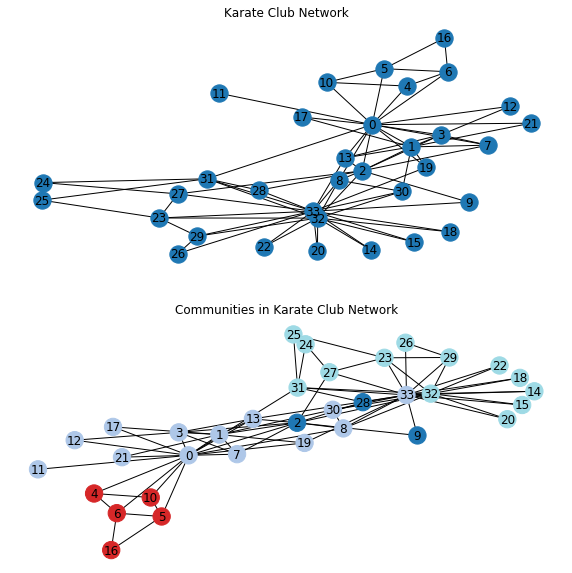

In [2]:
G = nx.karate_club_graph()

fig = plt.figure(figsize=(10, 10))
ax1 =  fig.add_subplot(211)
ax1.set_title('Karate Club Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               with_labels=True)

communities = louvain(G.copy())
values = [communities[node] for node in G.nodes()]            

ax2 = fig.add_subplot(212)
ax2.set_title('Communities in Karate Club Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values, 
               with_labels=True)
plt.show()  

#### Intermediate visualization: Karate Club Vizualization

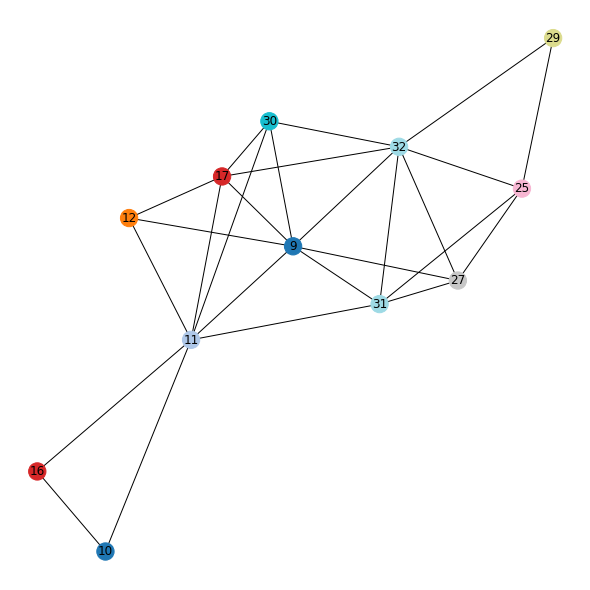

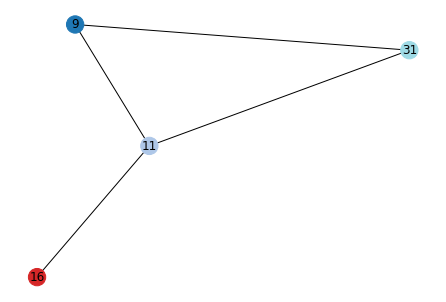

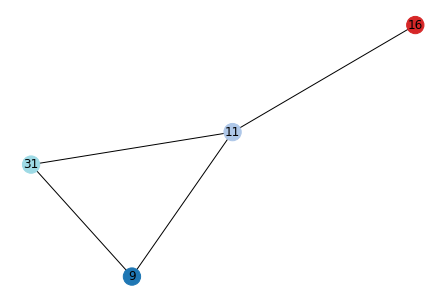

Finished community detection in: 0:00:00.421683


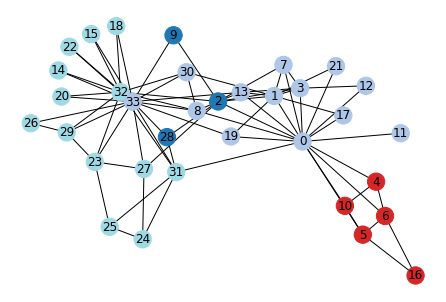

In [3]:
G = nx.karate_club_graph()

fig = plt.figure(figsize=(8, 8), )
communities = louvain(G.copy(), visualize=True)
values = [communities[node] for node in G.nodes()]            

fig.suptitle('Communities in Karate Club Network')
nx.draw_spring(G, 
               cmap=plt.get_cmap('tab20'), 
               node_color = values, 
               with_labels=True)
plt.show()           
